   The aim of this notebook is to work on the polarization of the cells

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
import seaborn as sns
import cv2 as cv
import math

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import set_init_point, prepare_tensions, adjust_tensions
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces

from scipy.interpolate import splprep, splev

Error: IPOPT shared library failed to import


Using TensorFlow backend.


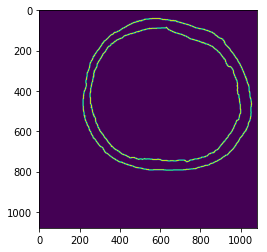

In [2]:
brightfield_path = '.././assets/sample_image_actin_surligned.tif'
img = cv.imread(brightfield_path, cv.IMREAD_GRAYSCALE).copy()
plt.show()
threshold = 2
_, img = cv.threshold(img, threshold, 255, 0)
blur = 9
img = cv.GaussianBlur(img, (blur, blur), 0)
plt.imshow(img)

img, contours, _ = cv.findContours(img, cv.RETR_TREE,
                                   cv.CHAIN_APPROX_SIMPLE)
contours = np.array(contours)

contours_length = np.array([c.size for c in contours])
membrane_ind = np.argsort(contours_length)[-2:]

retained_contours = contours[membrane_ind]

# Segmentation

[1992 1950 1716 1702]
Loading network weights from 'weights_best.h5'.


Reseting datasets values with new specs


0.9999999983951106
[[  -7.48230762 -107.20532446]
 [  -7.32080762 -107.36682446]
 [  -5.00597428 -107.4206578 ]
 ...
 [ -11.40543162 -107.15687446]
 [ -11.06651962 -107.17302446]
 [ -10.72781162 -107.18917446]]


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe01c80db70>)

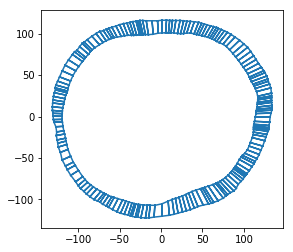

In [31]:
brigthfield_path = '.././assets/sample_image_actin_surligned.tif'
#dapi_path = '/home/fquinton/Documents/tyssue-taylor/assets/CELLPROFILER_sample_image_dapi.tiff.csv'
dapi_path = '.././assets/sample_image_dapi.tiff'
scp_path = '.././assets/star_convex_polynoms/models'
#initialising the mesh
organo, inners, outers, centers = generate_ring_from_image(brigthfield_path, dapi_path,
                                                           threshold=2,
                                                           method='SCP',
                                                           scp_model_path=scp_path,
                                                           rol_window_inside=20,
                                                           rol_window_outside=5)

#mlat = np.sum(inners[:, 0]) / len(inners)
#mlng = np.sum(inners[:, 1]) / len(inners)
#def algo(x):
#    return (math.atan2(x[0] - mlat, x[1] - mlng) + 2 * math.pi) % (2*math.pi)
#sort_inners = [list(inner) for inner in inners]
#sort_inners.sort(key=algo)
#inners = np.array(sort_inners)

#mlat = np.sum(outers[:, 0]) / len(outers)
#mlng = np.sum(outers[:, 1]) / len(outers)
#def algo(x):
#    return (math.atan2(x[0] - mlat, x[1] - mlng) + 2 * math.pi) % (2*math.pi)

#sort_outers = [list(outer) for outer in outers]
#sort_outers.sort(key=algo)
#outers = np.array(sort_outers)

Nf = organo.Nf
geom.update_all(organo)
#normalize_scale(organo, geom)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + np.sin(np.pi/Nf)/(np.mean(organo.face_df.area)*organo.settings['R_in']*np.sin(2*np.pi/Nf)-2*np.mean(organo.face_df.area)*
                             np.sin(2*np.pi/Nf)*(8-2*(np.sin(2*np.pi/Nf)**2-4)/(np.sin(np.pi/Nf)**4+8*np.sin(np.pi/Nf)**2)
                                                )*(organo.settings['R_in']+organo.settings['R_out']))
print(alpha)
alpha = 1.001
print(inners)

# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  list(alpha*organo.face_df.area.values), 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

#inners = inners[230:1175]

organo.update_specs(specs, reset=True)
geom.update_all(organo)

organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01

quick_edge_draw(organo)

In [18]:
organo.Nf

171

# Interpolation

/home/fquinton/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][2339]=x[0][0]
  (i, m, i)))
/home/fquinton/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][2339]=x[1][0]
  (i, m, i)))
/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/home/fquinton/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][2603]=x[0][0]
  (i, m, i)))
/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


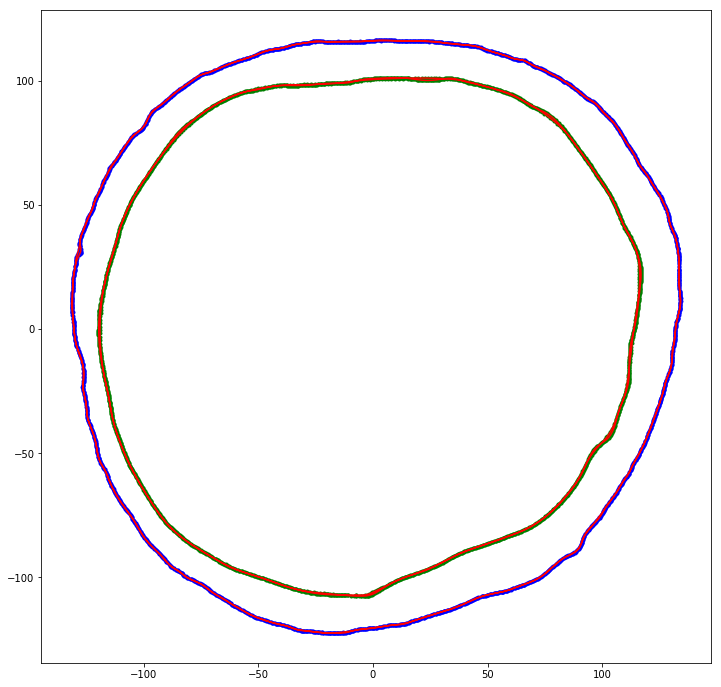

In [32]:
tck_inners, u_inners = splprep(inners.T, u=None, s=1e1, per=1) 
lins_inners = np.linspace(u_inners.min(), u_inners.max(), 1e3)
x_inners, y_inners = splev(lins_inners, tck_inners, der=0)

tck_outers, u_outers = splprep(outers.T, u=None, s=1e1, per=1) 
lins_outers = np.linspace(u_outers.min(), u_outers.max(), 1e3)
x_outers, y_outers = splev(lins_outers, tck_outers, der=0)

fig = plt.figure()
fig.set_size_inches(12, 12)
plt.plot(outers[:,0], outers[:,1], 'b.')
plt.plot(x_outers, y_outers, 'r-')
plt.plot(inners[:,0], inners[:,1], 'g.')
plt.plot(x_inners, y_inners, 'r-')
plt.show()

## Passing in polar coordinates

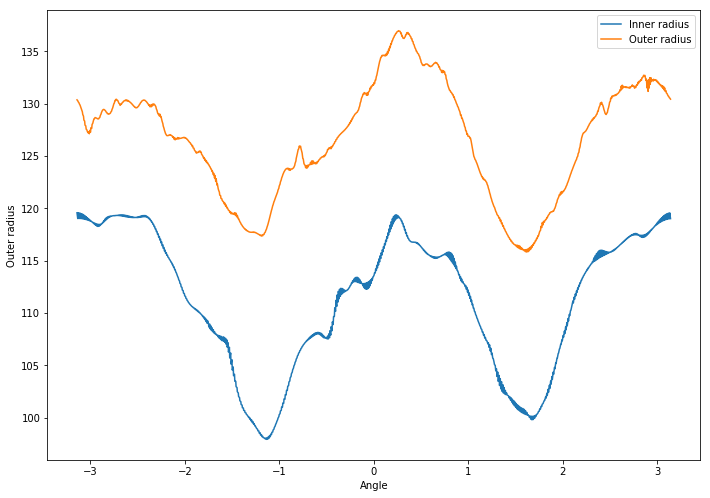

In [33]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

r_outers, p_outers = cart2pol(x_outers, y_outers)
r_inners, p_inners = cart2pol(x_inners, y_inners)

r_outers = r_outers[p_outers.argsort()]
r_inners = r_inners[p_inners.argsort()]

p_outers.sort()
p_inners.sort()

df = pd.DataFrame()
df['Angle'] = p_outers
df['Inner radius'] = r_inners
df['Outer radius'] = r_outers

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

sns.lineplot(x="Angle", y="Inner radius", ax=ax,
             data=df, label='Inner radius')
sns.lineplot(x="Angle", y="Outer radius", ax=ax,
             data=df, label='Outer radius')



Computing the difference between the two splines

In [34]:
diff = r_outers - r_inners
df['Difference'] = diff

Plotting the rolling mean of the difference for readable reasults

/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


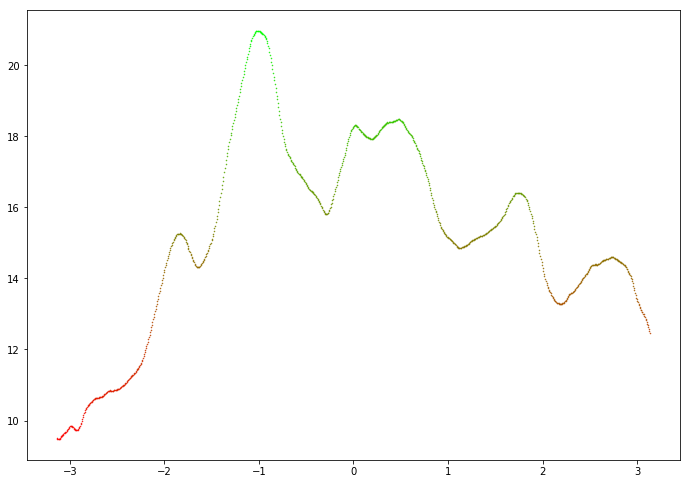

In [35]:
rolling_mean = df['Difference'].rolling(50, min_periods=1, center=True).mean()
df['Rolling average'] = rolling_mean

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(11.7, 8.27)

span_length = 1e3
y_span = np.linspace(df['Rolling average'].min(), df['Rolling average'].max(), span_length)
y_color_table = np.zeros(df['Rolling average'].shape)
for (ind, point) in enumerate(df['Rolling average']):
    box = 0
    while point>y_span[box]:
        box+=1
    y_color_table[ind] = box
    ax.plot(df['Angle'][ind],df['Rolling average'][ind],'.',markersize=1, color=((span_length-box)/span_length,
                                                                                 box/span_length,
                                                                                 0))

Put it back to cartesian coordinates

1000 1000


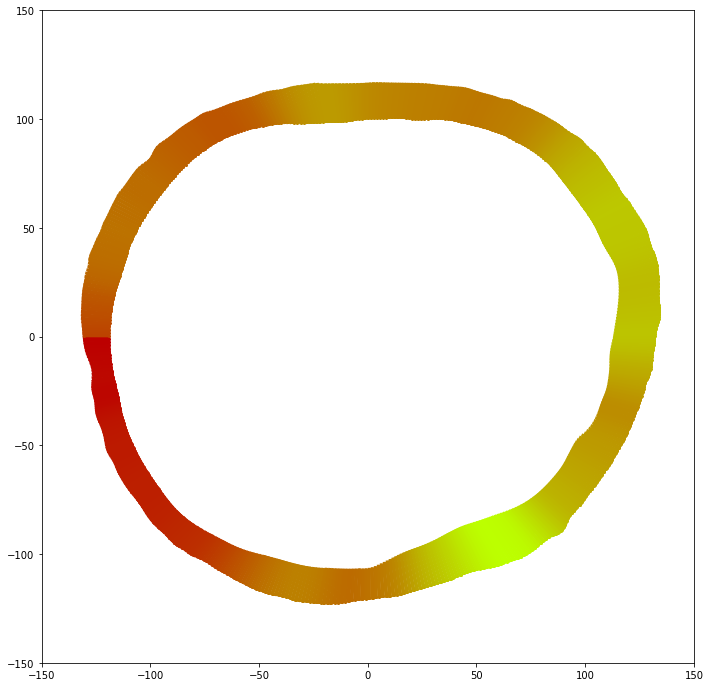

In [36]:
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

x_outers, y_outers = pol2cart(df['Outer radius'], df['Angle'])
x_inners, y_inners = pol2cart(df['Inner radius'], df['Angle'])

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(12, 12)
plt.xlim(-150, 150)
plt.ylim(-150, 150)
plt.gca().set_aspect('equal', adjustable='box')
print(len(x_inners), len(x_outers))

for (ind, point) in enumerate(y_inners):
    ax.plot(x_inners[ind], y_inners[ind], '.', markersize=1, color=((span_length-box)/span_length,
                                                                    y_color_table[ind]/span_length,
                                                                    0.0))
    ax.plot(x_outers[ind], y_outers[ind], '.', markersize=1, color=((span_length-box)/span_length,
                                                                    y_color_table[ind]/span_length,
                                                                    0.0))
    plt.plot([x_inners[ind], x_outers[ind]], [y_inners[ind], y_outers[ind]],
             marker='o',
             markersize=2,
             linewidth=3,
             color=((span_length-box)/span_length, y_color_table[ind]/span_length, 0))



In [37]:
[(np.cos(x / 10.), x / 10.) for x in range(-50, 50, 5)]

[(0.28366218546322625, -5.0),
 (-0.2107957994307797, -4.5),
 (-0.6536436208636119, -4.0),
 (-0.9364566872907963, -3.5),
 (-0.9899924966004454, -3.0),
 (-0.8011436155469337, -2.5),
 (-0.4161468365471424, -2.0),
 (0.0707372016677029, -1.5),
 (0.5403023058681398, -1.0),
 (0.8775825618903728, -0.5),
 (1.0, 0.0),
 (0.8775825618903728, 0.5),
 (0.5403023058681398, 1.0),
 (0.0707372016677029, 1.5),
 (-0.4161468365471424, 2.0),
 (-0.8011436155469337, 2.5),
 (-0.9899924966004454, 3.0),
 (-0.9364566872907963, 3.5),
 (-0.6536436208636119, 4.0),
 (-0.2107957994307797, 4.5)]

In [38]:
import pygal
from pygal.style import DefaultStyle 

from math import cos
xy_chart = pygal.XY(show_legend=False, show_dots=False)
xy_chart.title = 'XY Cosinus'
for (ind, point) in enumerate(y_inners):
    xy_chart.add('x = '+str(ind), [(y_inners[ind], x_inners[ind]), (y_outers[ind], x_outers[ind])])
xy_chart.render_to_file('/home/fquinton/Bureau/scatter_chart.svg')  

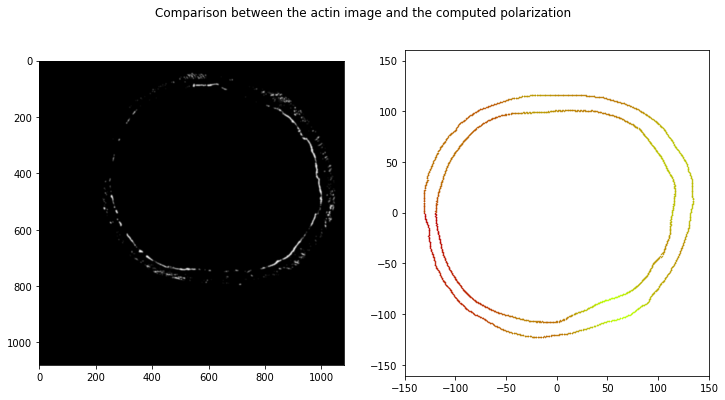

In [39]:
path = '../assets/sample_image_actin.tiff'

img = cv.imread(path,cv.IMREAD_GRAYSCALE)

copy = img.copy()
ret,copy = cv.threshold(copy,1,255,0)

f, (ax1, ax2) = plt.subplots(1, 2)
f.suptitle('Comparison between the actin image and the computed polarization')
f.set_size_inches(12, 6)
ax1.imshow(copy, cmap = 'gray', interpolation = 'bicubic')
plt.xlim(-150, 150)
plt.ylim(-110, 110)
plt.gca().set_aspect('equal', adjustable='datalim')
for (ind, point) in enumerate(y_inners):
    ax2.plot(x_inners[ind], y_inners[ind], '.', markersize=1, color=((span_length-box)/span_length,
                                                                    y_color_table[ind]/span_length,
                                                                    0.0))
for (ind, point) in enumerate(y_inners):
    ax2.plot(x_outers[ind], y_outers[ind], '.', markersize=1, color=((span_length-box)/span_length,
                                                                    y_color_table[ind]/span_length,
                                                                    0.0))


In [40]:
def print_tensions(exp_organo, th_organo):
    draw_specs = sheet_spec()
    tension_max = np.max(exp_organo.edge_df.line_tension.values)
    edge_color = 1/tension_max*exp_organo.edge_df.line_tension.values
    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['vert']['visible'] = False
    draw_specs['edge']['color'] = edge_cmap
    draw_specs['edge']['width'] = 0.25+3*edge_color
    fig, ax = quick_edge_draw(th_organo, lw=5, c='k', alpha=0.2)
    fig, ax = sheet_view(exp_organo, ax=ax, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')

In [60]:
organo.sgle_edges

AttributeError: 'AnnularSheet' object has no attribute 'sgle_edges'

Energy before optimization:  340.3654118881665
Energy after optimization:  12.336537147350429


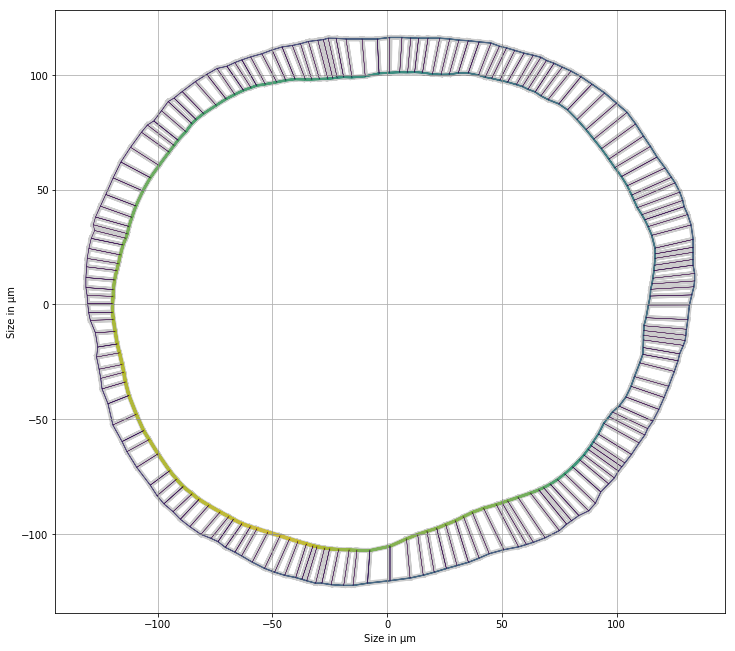

In [58]:
noisy = organo.copy()
initial_guess = infer_forces(organo, method='NNLS', compute_pressions=False, verbose=False)['tensions']
#initial_guess = set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha)
#initial_guess = np.maximum(np.zeros(int(organo.Ne*0.75)), infer_forces(organo)['tensions'])
start = time.clock()
copy_fi = noisy.copy()
print('Energy before optimization: ', model.compute_energy(copy_fi, False))
copy_fi.edge_df.line_tension = prepare_tensions(copy_fi, initial_guess)
res = Solver.find_energy_min(copy_fi, geom, model)
print('Energy after optimization: ', model.compute_energy(copy_fi, False))
#print(res)
print_tensions(copy_fi, organo)

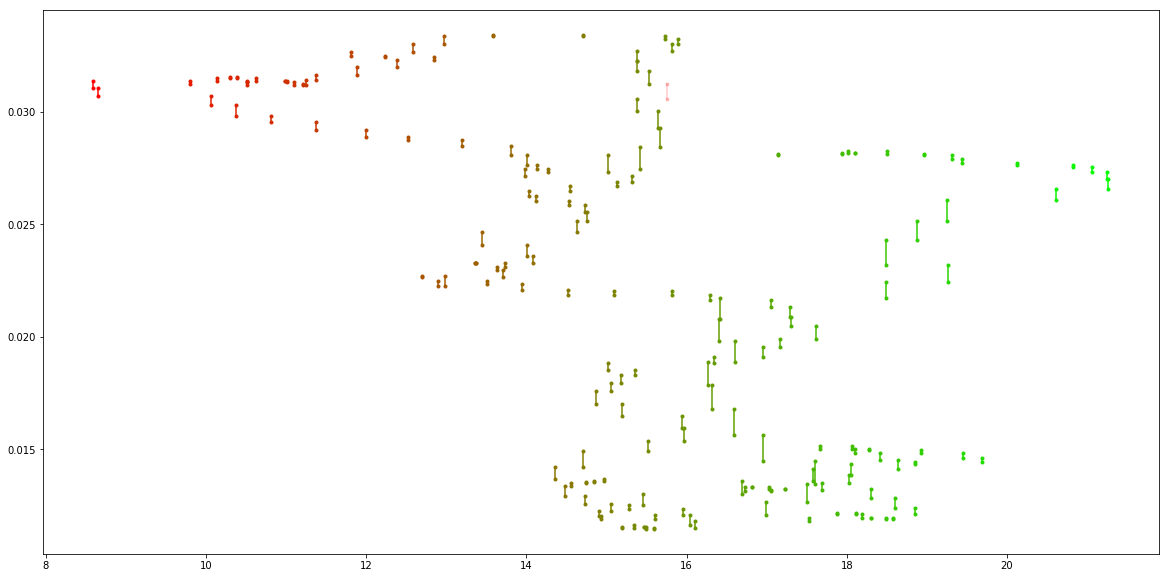

In [50]:
plt.figure(figsize=(20,10))
plt.plot([copy_fi.edge_df.length[2*organo.Nf]]*2,
         [copy_fi.edge_df.line_tension[organo.Nf-1],
         copy_fi.edge_df.line_tension[0]],
         'r-',
        [copy_fi.edge_df.length[2*organo.Nf]]*2,
         [copy_fi.edge_df.line_tension[organo.Nf-1],
         copy_fi.edge_df.line_tension[0]],
         'r.', alpha=0.2)
for lateral_edge in range(1, organo.Nf):
    color = ((np.max(copy_fi.edge_df.length[2*organo.Nf:])-copy_fi.edge_df.length[2*organo.Nf+lateral_edge])/
             (np.max(copy_fi.edge_df.length[2*organo.Nf:])-np.min(copy_fi.edge_df.length[2*organo.Nf:])),
             1-(np.max(copy_fi.edge_df.length[2*organo.Nf:])-copy_fi.edge_df.length[2*organo.Nf+lateral_edge])/
             (np.max(copy_fi.edge_df.length[2*organo.Nf:])-np.min(copy_fi.edge_df.length[2*organo.Nf:])),
             0)
    plt.plot([copy_fi.edge_df.length[2*organo.Nf+lateral_edge]]*2,
             copy_fi.edge_df.line_tension[(lateral_edge-1):lateral_edge+1].values,
             '-',
            [copy_fi.edge_df.length[2*organo.Nf+lateral_edge]]*2,
             copy_fi.edge_df.line_tension[(lateral_edge-1):lateral_edge+1].values,
             '.', color=color,
            alpha=1)
    